In [9]:
from datamanager import download_pdf_from_url, pdf_to_text, text_preprocessor
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor,ProcessPoolExecutor
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
import joblib

In [3]:
train = pd.read_excel('../data/DataSet.xlsx', sheet_name='train_data')
test = pd.read_excel('../data/DataSet.xlsx', sheet_name='test_data')

In [3]:
train['file_name'] = list(download_pdf_from_url(train.datasheet_link.tolist()[l], f'../pdf_files/train_{l}.pdf') for l in tqdm(range(len(train))))
test['file_name'] = list(download_pdf_from_url(test.datasheet_link.tolist()[l], f'../pdf_files/test_{l}.pdf') for l in tqdm(range(len(test))))

100%|██████████| 400/400 [01:14<00:00,  5.39it/s]


In [14]:
with ProcessPoolExecutor(max_workers=8) as executor:
    train['text'] = list(executor.map(pdf_to_text, train['file_name']))
    test['text'] = list(executor.map(pdf_to_text, test['file_name']))

In [19]:
train.to_csv('../data/train.csv')
test.to_csv('../data/test.csv')

#### Model building

In [4]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

##### TF-IDF with Decision Tree

In [5]:
with ProcessPoolExecutor(max_workers=8) as executor:
    train['text_preprocessed'] = list(executor.map(text_preprocessor, train['text'].astype(str)))
    test['text_preprocessed'] = list(executor.map(text_preprocessor, test['text'].astype(str)))

In [6]:
train = train[~train.text.isna()]
test = test[~test.text.isna()]
train, validation = train_test_split(train, test_size=0.25)

In [7]:
vectorizer = TfidfVectorizer()
le = LabelEncoder()
oe = OneHotEncoder()
train_X, train_Y = vectorizer.fit_transform(train.text_preprocessed), le.fit_transform(train.target_col)
valid_X, valid_Y = vectorizer.transform(validation.text_preprocessed), le.transform(validation.target_col)
test_X, test_Y = vectorizer.transform(test.text_preprocessed), le.transform(test.target_col)

In [18]:
vectorizer.transform(['Hi'])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 17358)>

In [20]:
le.classes_[3]

'others'

In [16]:
joblib.dump(le, "../models/label_encoder.joblib")
joblib.dump(vectorizer, "../models/vectorizer.joblib")

['../models/vectorizer.joblib']

In [ ]:
model = RandomForestClassifier()
model.fit(train_X, train_Y)
joblib.dump(model, "../models/rf.joblib")

RandomForestClassifier()

In [21]:
le.classes_[model.predict(vectorizer.transform(['Hi']))[0]]

'cable'

In [22]:
model.predict_proba(vectorizer.transform(['Hi']))[0]

array([0.64, 0.  , 0.02, 0.34])

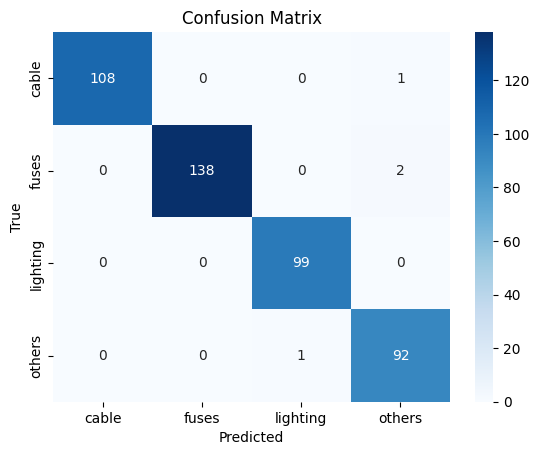

In [7]:
cm = confusion_matrix(valid_Y, model.predict(valid_X))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

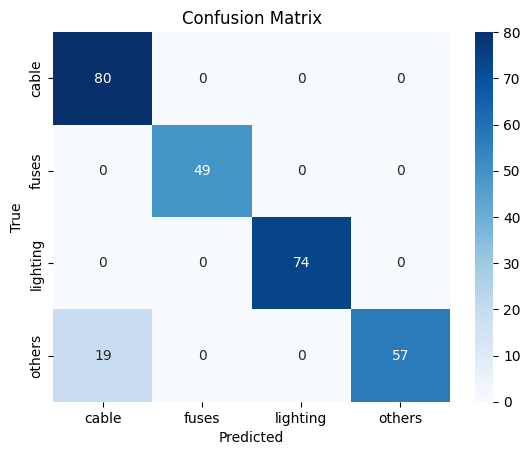

0.952020202020202

In [8]:
cm = confusion_matrix(test_Y, model.predict(test_X))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
precision_score(test_Y, model.predict(test_X), average='macro')

In [9]:
from transformers import AlbertTokenizer, TFAlbertModel
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

c:\Users\suman\data\parspec\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
import tensorflow as tf

In [20]:
from transformers import AlbertTokenizer

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

def tokenize_data(data):
    return tokenizer(
        data.tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )

train_encodings = tokenize_data(train.text_preprocessed)
val_encodings = tokenize_data(validation.text_preprocessed)
test_encodings = tokenize_data(test.text_preprocessed)


In [21]:
train['target_col_encoded'] = le.fit_transform(train.target_col)
validation['target_col_encoded'] = le.transform(validation.target_col)
test['target_col_encoded'] = le.fit_transform(test.target_col)

In [24]:
def create_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        tf.convert_to_tensor(labels, dtype=tf.int32)
    )).batch(32)

train_dataset = create_tf_dataset(train_encodings, train.target_col_encoded)
val_dataset = create_tf_dataset(val_encodings, validation.target_col_encoded)
test_dataset = create_tf_dataset(test_encodings, test.target_col_encoded)

from transformers import TFAlbertForSequenceClassification

model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=len(le.classes_))
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/10
42/42 [==============================] - 479s 11s/step - loss: 1.3930 - accuracy: 0.2874 - val_loss: 1.3745 - val_accuracy: 0.3197
Epoch 2/10
42/42 [==============================] - 472s 11s/step - loss: 1.3294 - accuracy: 0.3638 - val_loss: 1.2986 - val_accuracy: 0.4263
Epoch 3/10
42/42 [==============================] - 486s 12s/step - loss: 1.3840 - accuracy: 0.2995 - val_loss: 1.3794 - val_accuracy: 0.3175
Epoch 4/10
42/42 [==============================] - 399s 10s/step - loss: 1.3900 - accuracy: 0.2958 - val_loss: 1.3752 - val_accuracy: 0.3175
Epoch 5/10
42/42 [==============================] - 382s 9s/step - loss: 1.3925 - accuracy: 0.2965 - val_loss: 1.3754 - val_accuracy: 0.3175
Epoch 6/10
13/42 [========>.....................] - ETA: 3:42 - loss: 1.3980 - accuracy: 0.3197

KeyboardInterrupt: 